# Deep Learning - Model Training From Workshop material

First DL Model Training - Followed a workshop of MNIST 

### Import libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [13]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

## Load Data

We will begin by loading the MNIST data set and setting a few variables such as the number of epochs which we wish to train our Neural Network for.

In [55]:
num_epochs =100
num_classes = 10
batch_size= 128
learn_rate = 0.05
conv_epochs = 12
img_rows, img_cols = 28, 28

tr_loss, ts_loss, tr_acc, ts_acc = [], [], [], []

(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = trainX.astype('float32')
testX =testX.astype('float32')
trainX /= 255
testX /= 255

## Visualise the Data

To illustrate the shape of the data.

Training input shape:  (60000, 28, 28)
Training target shape:  (60000,)


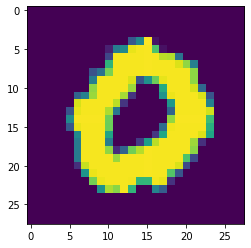

In [56]:
def show_random_image():
    i = random.randint(0,trainX.shape[0])
    input_image = trainX[i]
    plt.imshow(input_image)
    
show_random_image()

print("Training input shape: ", trainX.shape)
print("Training target shape: ", trainY.shape)

1) The target data `trainY` and `testY` should be one-hot-encoded. There are 10 classes.  
2) We wish to reshape the inputs (`trainX` and `testX`) to the Neural Network to be of shape (number of images, 784). For example, currently `trainX` is of shape (60000,28,28).

In [57]:
def get_one_hot(targets, nb_classes):

    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [58]:
trainX = trainX.reshape(-1,784)
testX = testX.reshape(-1,784)

trainY = get_one_hot(trainY, 10)
testY = get_one_hot(testY, 10)

## Create Activation Functions and Their Derivatives

The expressiveness of a Neural Net comes from applying non-linear activation functions. 

Remember that our inputs will be numpy arrays, not scalars.

In [59]:
def sigmoid(x):

    return 1/(1 + np.exp(-x))

def sigmoid_prime(x):

    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):

    return np.maximum(x, 0)
    
def relu_prime(x):

    return np.greater(x, 0).astype(int)
 
def softmax(x):

    expx = np.exp(x)
    return expx / expx.sum(axis=1, keepdims=True)


## Create Cost Function

In [60]:
def cost(y_truth, y_pred):
    return -((y_truth * np.log(y_pred)).sum())/y_pred.shape[0]

## Initialise Weights and Store Activations and their Derivatives

In [61]:
weights = [np.random.randn(*w) * 0.1 for w in [(784, 100), (100, 50), (50,10)]]
biases = [np.random.randn(*b) * 0.1 for b in [(100,), (50,), (10,)]]
activations = [(sigmoid, sigmoid_prime), (relu, relu_prime), (softmax, None)]

## Forward Propagation

In [62]:
def forward(X, weights, biases, act):
    a = [X]
    
    for w,b,f in zip(weights, biases, act):

        a.append(f[0](a[-1].dot(w) + b))
        
    return a

## Dimentionality Check

In [63]:
print("Our list of activations has 4 elements, each a numpy array")
print("Forward prop on first image: How does dimensionality work?")
a_test1 = forward(trainX[0].reshape(-1,784),weights, biases,activations)
for i in range(len(a_test1)):
    print("Layer ",i, " shape =",a_test1[i].shape)
 
print("Forward prop on batch of 10 images: How does dimensionality work?")  
a_test10 = forward(trainX[0:10].reshape(-1,784),weights, biases,activations)
for i in range(len(a_test10)):
    print("Layer ",i, " shape =",a_test10[i].shape)

Our list of activations has 4 elements, each a numpy array
Forward prop on first image: How does dimensionality work?
Layer  0  shape = (1, 784)
Layer  1  shape = (1, 100)
Layer  2  shape = (1, 50)
Layer  3  shape = (1, 10)
 
Forward prop on batch of 10 images: How does dimensionality work?
Layer  0  shape = (10, 784)
Layer  1  shape = (10, 100)
Layer  2  shape = (10, 50)
Layer  3  shape = (10, 10)


## Calculate the Gradients of our Error with respect to all the Neural Network Parameters

Here we will use backpropogation.


In [64]:
def gradients(X, Y, weights, biases, act):
    # Perform a forward pass and store the return values in a variable named a:

    a = forward(X, weights, biases, activations)

    #Inialise gradients of weights and biases
    gradients = np.empty_like(weights)
    grad_bias = np.empty_like(biases)

    #Perform back propogation on the output layer only
    #to understand how this works examine the differential of the loss function
    delta = a[-1] - Y
    gradients[-1] = a[-2].T.dot(delta)
    grad_bias[-1] = np.sum(delta, axis=0)

    for i in range(len(a)-2,0,-1):
        #For each layer calculate the gradients
        
        delta = act[i-1][1](a[i]) * delta.dot(weights[i].T)
        grad_bias[i-1] = np.sum(delta, axis=0)
        gradients[i-1] = a[i-1].T.dot(delta)
    

    #Divide weight gradients and biases by the batch size
    
    grad_bias = grad_bias / len(X)
    gradients = gradients / len(X)


    return gradients, grad_bias

In [72]:
print("Gradients and biases - : How does dimensionality work?")
a = forward(trainX[0].reshape(-1,784),weights, biases,activations)

for i in range(len(weights)):
    grad_test1, grad_bias1 = gradients(trainX[0].reshape(-1,784), trainY[0], weights, biases, activations)
    print("Layer :", i, " Gradients, Biases - shape =", grad_test1[i].shape, grad_bias1[i].shape) 

Gradients and biases - : How does dimensionality work?
Layer : 0  Gradients, Biases - shape = (784, 100) (100,)
Layer : 1  Gradients, Biases - shape = (100, 50) (50,)
Layer : 2  Gradients, Biases - shape = (50, 10) (10,)


## Train the Neural Network

The outer loop will be the number of epochs we wish to perform, for each epoch we will loop in batches, thus this is mini-batch gradient descent.

__Task:__   
1) Within the inner loop calculate the gradients and biases and store in variables `gradw`, `biases`.   
2) Within the inner loop update the `weights` and `biases` using the respective gradients, and set the step size via the variable `learn_rate` defined earlier.   
3) In the outer loop create predictions on the training and test set, then store the results in variables `trpreds`, `tstpreds`.    
4) Next calculate the training and test cost, and store the results in variables `ctr`, `cst`.

We will choose the argmax of those predictions and use this to calculate our the accuracy of our predictions.


In [66]:
for i in range(num_epochs):
    for j in range(0, len(trainX), batch_size):
        X, Y = trainX[j:j+batch_size], trainY[j:j+batch_size]
        
        gradw, grad_bias = gradients(X, Y, weights, biases, activations)
        biases -= learn_rate * grad_bias
        weights -= learn_rate * gradw
    
    trpreds = forward(trainX, weights, biases, activations)[-1]
    tstpreds = forward(testX, weights, biases, activations)[-1]
    ctr = cost(trainY, trpreds)
    cst = cost(testY, tstpreds)

    tr_loss.append(ctr)
    ts_loss.append(cst)
    
    trpred_onehot = np.argmax(trpreds, axis=1)
    tstpred_onehot = np.argmax(tstpreds, axis=1)
    
    train_acc = np.mean(trpred_onehot == np.argmax(trainY, axis=1))
    test_acc = np.mean(tstpred_onehot == np.argmax(testY, axis=1))
    tr_acc.append(train_acc)
    ts_acc.append(test_acc)
    
    if i%5==0:
        print("Epoch:", i, "Tr_loss:", ctr, "Tst_loss:", cst , "Tr_acc:",train_acc, "Tst_acc:", test_acc)

Epoch: 0 Tr_loss: 0.8187912019460861 Tst_loss: 0.7991829930306033 Tr_acc: 0.7668833333333334 Tst_acc: 0.77
Epoch: 5 Tr_loss: 0.3100980752148637 Tst_loss: 0.29796272847852784 Tr_acc: 0.9093 Tst_acc: 0.9116
Epoch: 10 Tr_loss: 0.26741066870445035 Tst_loss: 0.2616761967080491 Tr_acc: 0.9218166666666666 Tst_acc: 0.9246
Epoch: 15 Tr_loss: 0.2415059605965725 Tst_loss: 0.24009305352314828 Tr_acc: 0.9290666666666667 Tst_acc: 0.9286
Epoch: 20 Tr_loss: 0.2201034819413394 Tst_loss: 0.2218559564157161 Tr_acc: 0.9355333333333333 Tst_acc: 0.9339
Epoch: 25 Tr_loss: 0.20096579147191032 Tst_loss: 0.20519958208216404 Tr_acc: 0.9409166666666666 Tst_acc: 0.9387
Epoch: 30 Tr_loss: 0.18362473907836502 Tst_loss: 0.1897801769216532 Tr_acc: 0.9462333333333334 Tst_acc: 0.9427
Epoch: 35 Tr_loss: 0.1681133045966336 Tst_loss: 0.17587393375416813 Tr_acc: 0.9507833333333333 Tst_acc: 0.9461
Epoch: 40 Tr_loss: 0.15464478125159173 Tst_loss: 0.16405645887716008 Tr_acc: 0.9544833333333334 Tst_acc: 0.9511
Epoch: 45 Tr_loss

Text(0.5, 0, 'Epoch')

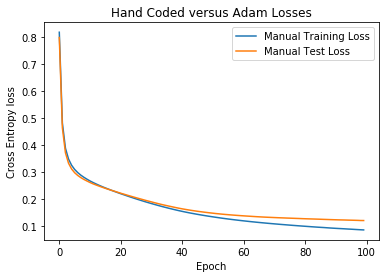

In [69]:
plt.plot(tr_loss, label='Manual Training Loss')
plt.plot(ts_loss, label='Manual Test Loss')

plt.legend()
plt.title('Hand Coded versus Adam Losses')
plt.ylabel('Cross Entropy loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

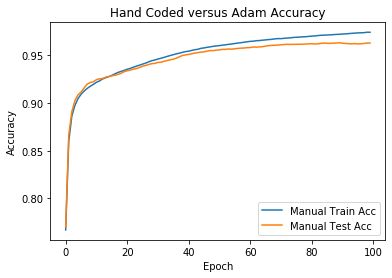

In [70]:
plt.plot(tr_acc, label='Manual Train Acc')
plt.plot(ts_acc, label='Manual Test Acc')

plt.legend()
plt.title('Hand Coded versus Adam Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

Examine Predictions

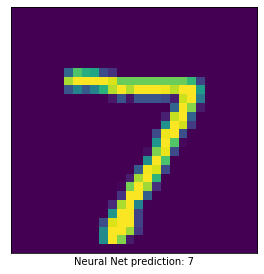

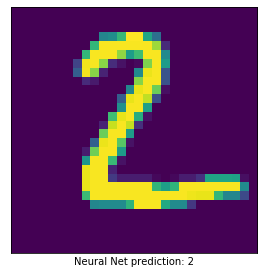

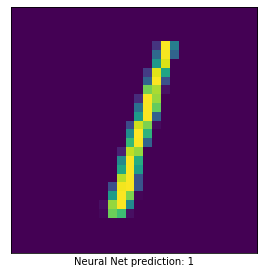

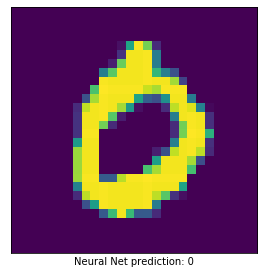

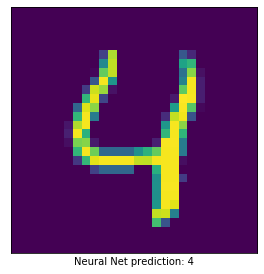

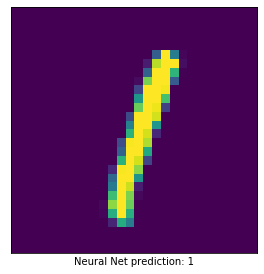

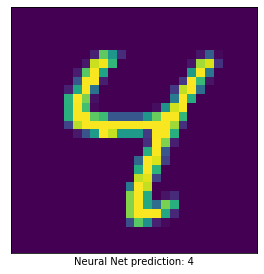

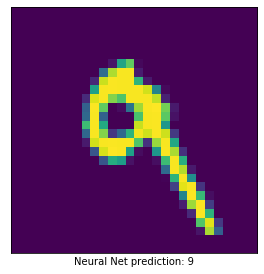

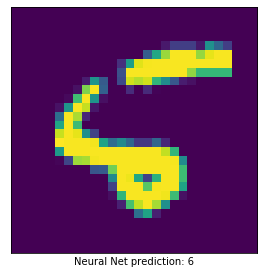

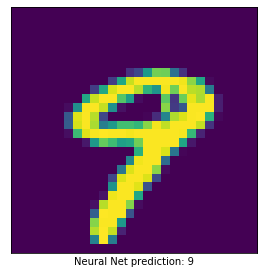

In [71]:
for i in range(10):
    input_image = testX[i].reshape(1,784)
    
    tstpreds = forward(input_image, weights, biases, activations)[-1]
    
    fig            = plt.figure(i, figsize=(15, 11))
    ax = plt.subplot(1, 3, 1)
    ax.set_xticks(())
    ax.set_yticks(())
    plt.imshow(input_image.reshape(28,28))
    plt.xlabel("Neural Net prediction: " + str(np.argmax(tstpreds)))

Next: DL Training First hand